# Evaluate

In [41]:
import logging
from os import listdir
from os.path import join
import pickle
import nltk
import json
from tqdm import tqdm_notebook

import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
from sklearn.datasets import load_svmlight_files
from sklearn.model_selection import train_test_split

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

from code.model import NativeLanguageCNN
from code.train import read_data
from scripts.baseline_util import ivectors_dict_to_features

### Read data

In [4]:
feature_dir = "data/features/speech_transcriptions/ngrams/2"
train_label_file = "data/labels/train/labels.train.csv"
dev_label_file = "data/labels/dev/labels.dev.csv"
max_len = 600

In [5]:
# Read feature dictionary
with open(join(feature_dir, 'dict.pkl'), 'rb') as fpkl:
    (feature_dict, feature_rev_dict) = pickle.load(fpkl)
n_features = len(feature_dict)

# Read dev set data + labels
(dev_mat, dev_label, lang_dict) = read_data(join(feature_dir, 'dev'),
                                            dev_label_file, 0, n_features, max_len)
(train_mat, train_label, _) = read_data(join(feature_dir, 'train'), train_label_file, 
                                        0, n_features, max_len)

n_lang = len(lang_dict)
print(dev_mat.shape)
print(len(dev_label))

(1100, 600)
1100


### Restore model from state

In [6]:
model_state_file0 = "model/2017-06-05-213530/model-state-0050.pkl"
model_state_file1 = "model/2017-06-05-213530/model-state-0045.pkl"
model_state_file2 = "model/2017-06-05-213530/model-state-0040.pkl"
model_state_file3 = "model/2017-06-05-213530/model-state-0035.pkl"
model_state_file4 = "model/2017-06-05-213530/model-state-0030.pkl"

max_len = 600
embed_dim = 500
channel = 500

def restore_model(model_state_file, max_len, embed_dim, channel):
    nlcnn_model = NativeLanguageCNN(n_features, embed_dim, 0, channel, n_lang)
    map_location = {'cuda:0':'cpu'}  # move CUDA variables to CPU
    nlcnn_model.load_state_dict(torch.load(model_state_file, map_location={'cuda:0':'cpu'}))
    nlcnn_model.eval()
    return nlcnn_model

In [7]:
# Restore model from saved model state
nlcnn_model0 = restore_model(model_state_file0, max_len, embed_dim, channel)
nlcnn_model1 = restore_model(model_state_file1, max_len, embed_dim, channel)
nlcnn_model2 = restore_model(model_state_file2, max_len, embed_dim, channel)
nlcnn_model3 = restore_model(model_state_file3, max_len, embed_dim, channel)
nlcnn_model4 = restore_model(model_state_file4, max_len, embed_dim, channel)

## Model evaluation

### Confusion Matrices and F1 Scores

In [17]:
def evaluate_model(model, dev_mat, dev_label, cuda=True):
    model.eval().cpu()
    if cuda:
        model.cuda()
    dev_tensor = torch.from_numpy(dev_mat)
    if cuda:
        dev_tensor = dev_tensor.cuda()
    dev_mat_var = Variable(dev_tensor)
    dev_score = model(dev_mat_var)
    return dev_score.data.cpu().numpy()

def get_conf_report(dev_pred, dev_label, lang_dict):
    dev_pred_lang = [lang_dict[lb] for lb in dev_pred]
    dev_lang = [lang_dict[lb] for lb in dev_label]
    conf_mat = confusion_matrix(dev_lang, dev_pred_lang)
    report = classification_report(dev_lang, dev_pred_lang)
    return (conf_mat, report)

def plot_conf_mat(conf_mat, lang_label, fname="conf_mat.png"):
#     plt.figure(figsize=(8, 8))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.set_style("white")
    sns.heatmap(conf_mat, annot=True, cmap=cmap, fmt="d", linewidths=1, square=True,
                xticklabels=lang_label, yticklabels=lang_label)
    plt.savefig(fname, dpi=300, bbox_inches='tight')

In [48]:
dev_score0 = evaluate_model(nlcnn_model0, dev_mat, dev_label)
dev_score1 = evaluate_model(nlcnn_model1, dev_mat, dev_label)
dev_score2 = evaluate_model(nlcnn_model2, dev_mat, dev_label)
dev_score3 = evaluate_model(nlcnn_model3, dev_mat, dev_label)
# dev_score4 = evaluate_model(nlcnn_model4, dev_mat, dev_label)
dev_score = sum((dev_score0, dev_score1, dev_score2, dev_score3))
dev_pred = np.argmax(dev_score, axis=1)

/usr/lib/anaconda3/envs/sergey/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


             precision    recall  f1-score   support

        ARA       0.42      0.48      0.45       100
        CHI       0.59      0.52      0.55       100
        FRE       0.51      0.44      0.47       100
        GER       0.65      0.59      0.62       100
        HIN       0.50      0.52      0.51       100
        ITA       0.56      0.63      0.59       100
        JPN       0.51      0.56      0.53       100
        KOR       0.54      0.51      0.52       100
        SPA       0.45      0.47      0.46       100
        TEL       0.57      0.52      0.54       100
        TUR       0.53      0.55      0.54       100

avg / total       0.53      0.53      0.53      1100



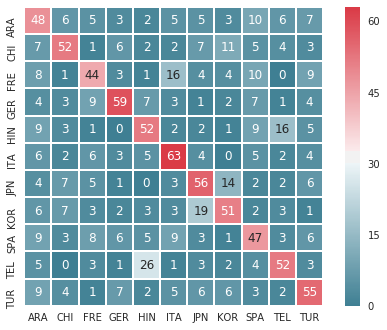

In [60]:
(conf_mat, report) = get_conf_report(dev_pred, dev_label, lang_dict)
plot_conf_mat(conf_mat, sorted(lang_dict.values()), fname="cnn_conf_mat.png")
print(report)

## Network Visualization

### Character Bigram Embeddings

In [18]:
def plot_embeddings(wv, vocab):
    tsne = TSNE(n_components=2, random_state=0)
#     np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(wv)

    plt.figure(figsize=(10, 10))
    plt.scatter(Y[:, 0], Y[:, 1])
    for label, x, y in zip(vocab, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()

/usr/lib/anaconda3/envs/sergey/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


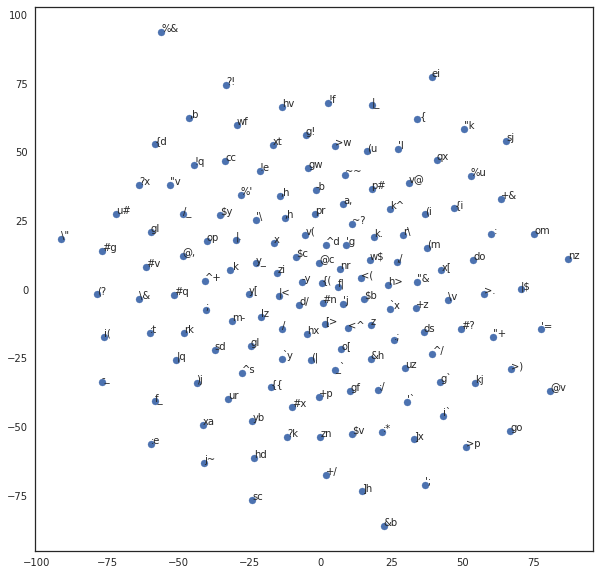

In [20]:
with open(join(feature_dir, 'dict.pkl'), 'rb') as fpkl:
    (feature_dict, feature_rev_dict) = pickle.load(fpkl)

embeddings = nlcnn_model0.embed.weight.data.cpu().numpy()
indices = np.random.choice(embeddings.shape[0] - 1, 150)
bigrams = [''.join(feature_dict[i]) for i in indices]
plot_embeddings(embeddings[indices], bigrams)

### Saliency maps

In [28]:
file_dir = "data/speech_transcriptions/train/tokenized"
# file_dir = "data/speech_transcriptions/dev/tokenized"
df_train_label = pd.read_csv(train_label_file)
df_dev_label = pd.read_csv(dev_label_file)

In [57]:
def get_embed_grad(model, X, y, cuda=True):
    model.eval()
    if cuda:
        X = X.cuda()
        model.cuda()
    X_var = Variable(X).unsqueeze(0)
    scores = model(X_var)
    loss = scores[0, y]
    loss.backward()
    embed_grad = model.embed.weight.grad.sum(dim=1).abs().squeeze().data
    return embed_grad.cpu().numpy()

def plot_saliency_map(model, X, y, df_label, test_id=None, width=20):
    if not test_id:
        test_id = np.random.choice(df_label['test_taker_id'].tolist())
    file_name = "{:05d}.txt".format(test_id)
    idx = df_label[df_label['test_taker_id'] == test_id].index.tolist()[0]
    print(df_label[df_label['test_taker_id'] == test_id])
    
    embed_grad = get_embed_grad(model, torch.LongTensor(X[idx]), y[idx])
    lines = open(join(file_dir, file_name)).readlines()
    
    for (l, ln) in enumerate(lines):
        ln_low = ln.lower()
        grad = []
        annot = []
        
        for i in range(len(ln) - 1):
#             if ln[i] is ' ':
#                 annot.append(ln[i])
#                 grad.append(0)
#                 continue
                
            bigram = (ln_low[i], ln_low[i + 1])
#             if ln_low[i + 1] == ' ':
#                 bigram = (ln_low[i], ln_low[i + 2])
                
            if bigram not in feature_rev_dict:
                annot.append(ln[i])
                grad.append(0)
                continue
            
            annot.append(ln[i])
            grad.append(embed_grad[feature_rev_dict[bigram]])
        
        plt.figure(figsize=(8, 10))
        grad += [0] * (width - len(grad) % width)
        annot += [''] * (width - len(annot) % width)
        grad = np.array(grad).reshape(-1, width)
        annot = np.array(annot).reshape(-1, width)
        sns.set_style("white")
        cmap = sns.cubehelix_palette(5, dark=0, light=1, rot=-.25, as_cmap=True)
        sns.heatmap(grad, annot=annot, fmt = '', square=True, cbar=False, cmap=cmap,
                    xticklabels=[''] * grad.shape[0], yticklabels=[''] * grad.shape[1])
        plt.savefig("{:05d}_l{:d}_saliency_map.png".format(test_id, l), dpi=300, bbox_inches='tight')
        plt.show()

      test_taker_id speech_prompt essay_prompt   L1
4208           5055            P8           P7  TUR


/usr/lib/anaconda3/envs/sergey/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


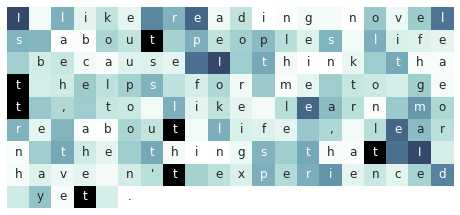

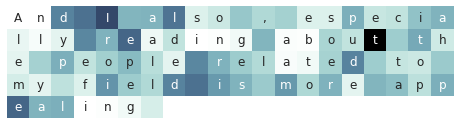

In [90]:
plot_saliency_map(nlcnn_model1, train_mat, train_label, df_train_label, width=20)

      test_taker_id speech_prompt essay_prompt   L1
3746           4502            P1           P2  SPA


/usr/lib/anaconda3/envs/sergey/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


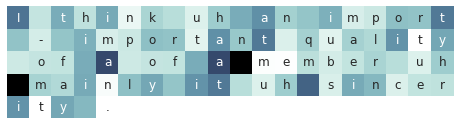

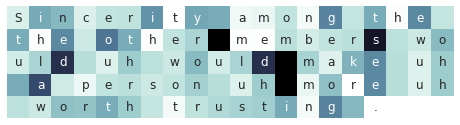

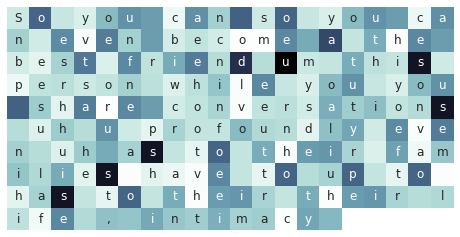

In [39]:
plot_saliency_map(nlcnn_model0, train_mat, train_label, df_train_label, test_id=4502, width=20)

      test_taker_id speech_prompt essay_prompt   L1
2387           2884            P2           P3  HIN


/usr/lib/anaconda3/envs/sergey/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


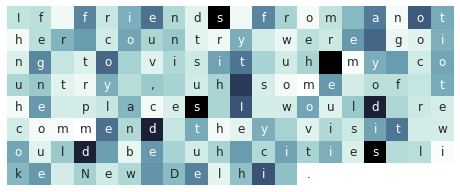

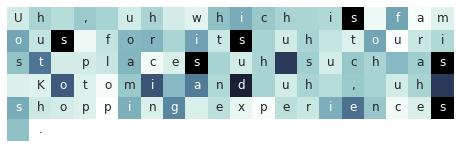

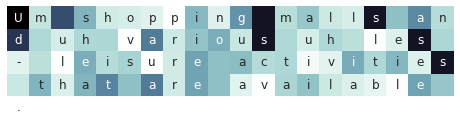

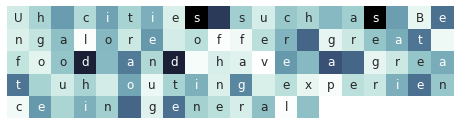

In [40]:
plot_saliency_map(nlcnn_model0, train_mat, train_label, df_train_label, test_id=2884, width=20)

      test_taker_id speech_prompt essay_prompt   L1
7631           9162            P9           P0  SPA


/usr/lib/anaconda3/envs/sergey/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


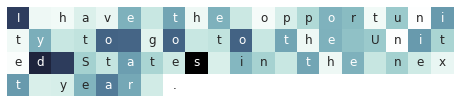

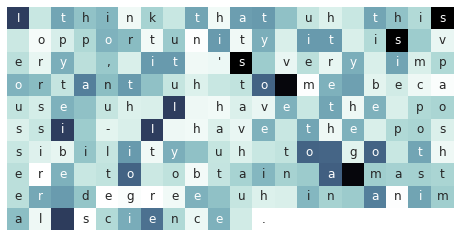

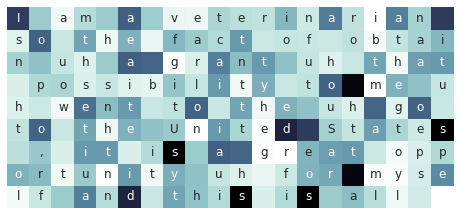

In [41]:
plot_saliency_map(nlcnn_model0, train_mat, train_label, df_train_label, test_id=9162, width=20)

## Grammar rules

In [42]:
train_gram_feature_file = 'data/features/speech_transcriptions/grammar/train/train_norm_gram_features.txt'
dev_gram_feature_file = 'data/features/speech_transcriptions/grammar/dev/dev_norm_gram_features.txt'
train_gram_mat = np.loadtxt(train_gram_feature_file, delimiter=',')
dev_gram_mat = np.loadtxt(dev_gram_feature_file, delimiter=',')
print(train_gram_mat.shape)
print(dev_gram_mat.shape)

(11000, 37)
(1100, 37)


In [43]:
clf = LinearSVC()
clf.fit(train_gram_mat, train_label)
dev_pred = clf.predict(dev_gram_mat)

/usr/lib/anaconda3/envs/sergey/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


             precision    recall  f1-score   support

        ARA       0.13      0.06      0.08       100
        CHI       0.20      0.09      0.12       100
        FRE       0.19      0.13      0.15       100
        GER       0.22      0.42      0.29       100
        HIN       0.21      0.30      0.24       100
        ITA       0.23      0.40      0.30       100
        JPN       0.18      0.20      0.19       100
        KOR       0.22      0.18      0.20       100
        SPA       0.22      0.19      0.20       100
        TEL       0.27      0.22      0.24       100
        TUR       0.16      0.11      0.13       100

avg / total       0.20      0.21      0.20      1100



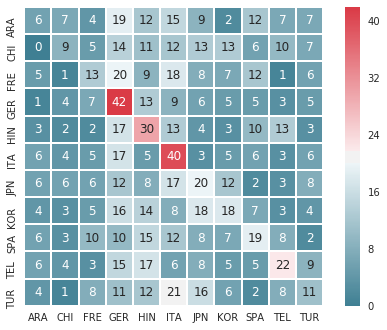

In [46]:
(conf_mat, report) = get_conf_report(dev_pred, dev_label, lang_dict)
plot_conf_mat(conf_mat, sorted(lang_dict.values()))
print(report)

## Combined SVM Evaluation

### Loading features

Native Language CNN

In [8]:
def evaluate_model_in_batch(model, mat, label, batch=100, cuda=True):
    mat_tensor = torch.from_numpy(mat)
    label_tensor = torch.LongTensor(label)
    dataset = TensorDataset(mat_tensor, label_tensor)
    sampler = SequentialSampler(dataset)
    data_loader = DataLoader(dataset, batch_size=batch, sampler=sampler)
    
    model.cuda().eval()  # move model to GPU and set to eval mode
    scores = []
    ys = []
    
    for (x, y) in tqdm_notebook(data_loader):
        if cuda:
            x = x.cuda()
            y = y.cuda()
        score = F.softmax(model(Variable(x)))
        scores.append(score.data.cpu().numpy())
        ys.append(y.cpu().numpy())
    scores = np.vstack(scores)
    ys = np.hstack(ys)
    return scores, ys

In [9]:
train_score = []
dev_score = []
for model in tqdm_notebook((nlcnn_model0, nlcnn_model1, nlcnn_model2, nlcnn_model3)):
    scores, ys = evaluate_model_in_batch(model, train_mat, train_label)
    train_score.append(scores)
    assert np.array_equal(train_label, ys)
    scores, ys = evaluate_model_in_batch(model, dev_mat, dev_label)
    dev_score.append(scores)
    assert np.array_equal(dev_label, ys)

train_score = sum(train_score) / len(train_score)
dev_score = sum(dev_score) / len(train_score)

i-vectors

In [10]:
train_ivectors_path = 'data/features/ivectors/train/ivectors.json'
dev_ivectors_path = 'data/features/ivectors/dev/ivectors.json'

train_ivectors_dict = json.load(open(train_ivectors_path, 'r'))
dev_ivectors_dict = json.load(open(dev_ivectors_path, 'r'))
train_ivectors_mat = ivectors_dict_to_features(train_ivectors_dict, 'train')
dev_ivectors_mat = ivectors_dict_to_features(dev_ivectors_dict, 'dev')

print(train_ivectors_mat.shape)
print(dev_ivectors_mat.shape)

(11000, 800)
(1100, 800)


Transcript features

In [11]:
train_feature_file = 'data/features/speech_transcriptions/train/train-2017-06-06-21.14.28.features'
dev_feature_file = 'data/features/speech_transcriptions/dev/dev-2017-06-06-21.14.30.features'

train_transcipt_mat, encoded_train_label, dev_transcipt_mat, encoded_dev_label = \
    load_svmlight_files((train_feature_file, dev_feature_file))
train_transcipt_mat = train_transcipt_mat.toarray()
dev_transcipt_mat = dev_transcipt_mat.toarray()

assert np.array_equal(encoded_train_label, train_label)
assert np.array_equal(encoded_dev_label, dev_label)

print(train_transcipt_mat.shape)
print(dev_transcipt_mat.shape)

(11000, 13593)
(1100, 13593)


Grammar rules feature

In [12]:
train_gram_feature_file = 'data/features/speech_transcriptions/grammar/train/train_norm_gram_features.txt'
dev_gram_feature_file = 'data/features/speech_transcriptions/grammar/dev/dev_norm_gram_features.txt'
train_gram_mat = np.loadtxt(train_gram_feature_file, delimiter=',')
dev_gram_mat = np.loadtxt(dev_gram_feature_file, delimiter=',')
print(train_gram_mat.shape)
print(dev_gram_mat.shape)

(11000, 37)
(1100, 37)


## Tune SVM Hyperparameter

Create combined matrix

In [42]:
train_combined_mat = hstack((csr_matrix(train_score),
                             csr_matrix(train_ivectors_mat),
                             csr_matrix(train_gram_mat),
                             train_transcipt_mat))
dev_combined_mat = hstack((csr_matrix(dev_score),
                           csr_matrix(dev_ivectors_mat),
                           csr_matrix(dev_gram_mat),
                           dev_transcipt_mat))
print(train_combined_mat.shape)
print(len(train_label))
print(dev_combined_mat.shape)
print(len(dev_label))

(11000, 14441)
11000
(1100, 14441)
1100


In [43]:
(train_split_mat, val_split_mat, train_split_label, val_split_label) = \
            train_test_split(train_combined_mat, train_label, test_size=0.1)

clf_split = LinearSVC(C=0.1)
clf_split.fit(train_split_mat, train_split_label)

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [55]:
val_split_pred = clf_split.predict(val_split_mat)
print("validation F1 = {:.3f}".format(np.mean(val_split_pred == val_split_label)))

validation F1 = 0.668


### Final results on dev set

In [56]:
clf = LinearSVC(C=0.1)
clf.fit(train_combined_mat, train_label)

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [61]:
dev_pred = clf.predict(dev_combined_mat)

/usr/lib/anaconda3/envs/sergey/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


             precision    recall  f1-score   support

        ARA       0.86      0.76      0.81       100
        CHI       0.82      0.79      0.81       100
        FRE       0.77      0.75      0.76       100
        GER       0.89      0.90      0.90       100
        HIN       0.70      0.79      0.74       100
        ITA       0.77      0.78      0.78       100
        JPN       0.80      0.89      0.84       100
        KOR       0.70      0.81      0.75       100
        SPA       0.73      0.67      0.70       100
        TEL       0.77      0.70      0.73       100
        TUR       0.91      0.85      0.88       100

avg / total       0.79      0.79      0.79      1100



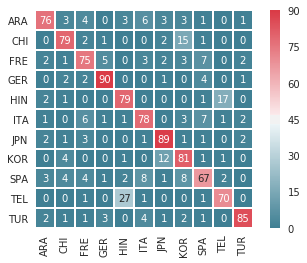

In [62]:
(conf_mat, report) = get_conf_report(dev_pred, dev_label, lang_dict)
plot_conf_mat(conf_mat, sorted(lang_dict.values()), fname="fusion_conf_mat.png")
print(report)